In [31]:
from PIL import Image
import torch
import os
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
from models.VGG16_model import Feature_Extractor
from torchvision import transforms

In [32]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Feature_Extractor()
model = model.to(device=device)
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Using cache found in C:\Users\Suchira/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\Suchira\anaconda3\envs\research\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Suchira\anaconda3\envs\research\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [33]:
def get_reference_image(inference_folder_path):
    """Returns the first image in the given folder"""
    images = os.listdir(inference_folder_path)
    image = images[0]
    image_path = os.path.join(inference_folder_path, image)
    image = Image.open(image_path)
    return image

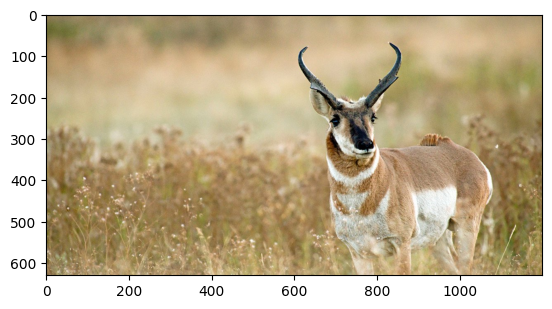

In [34]:
inference_image = get_reference_image(inference_folder_path='./inference_image/')
plt.imshow(np.asarray(inference_image))

In [35]:
reference_dataset_folder_path = './data/animals/animals'

In [36]:
reference_classes = os.listdir(reference_dataset_folder_path)
print(reference_classes)

['antelope', 'badger', 'bat', 'bear', 'bee', 'beetle', 'bison', 'boar', 'butterfly', 'cat', 'caterpillar', 'chimpanzee', 'cockroach', 'cow', 'coyote', 'crab', 'crow', 'deer', 'dog', 'dolphin', 'donkey', 'dragonfly', 'duck', 'eagle', 'elephant', 'flamingo', 'fly', 'fox', 'goat', 'goldfish', 'goose', 'gorilla', 'grasshopper', 'hamster', 'hare', 'hedgehog', 'hippopotamus', 'hornbill', 'horse', 'hummingbird', 'hyena', 'jellyfish', 'kangaroo', 'koala', 'ladybugs', 'leopard', 'lion', 'lizard', 'lobster', 'mosquito', 'moth', 'mouse', 'octopus', 'okapi', 'orangutan', 'otter', 'owl', 'ox', 'oyster', 'panda', 'parrot', 'pelecaniformes', 'penguin', 'pig', 'pigeon', 'porcupine', 'possum', 'raccoon', 'rat', 'reindeer', 'rhinoceros', 'sandpiper', 'seahorse', 'seal', 'shark', 'sheep', 'snake', 'sparrow', 'squid', 'squirrel', 'starfish', 'swan', 'tiger', 'turkey', 'turtle', 'whale', 'wolf', 'wombat', 'woodpecker', 'zebra']


In [37]:
def inference_for_pair(inference_image, reference_image):
    inference_image = transform(inference_image)
    reference_image = transform(reference_image)
    
    inference_image = torch.unsqueeze(inference_image, 0).to(device)
    reference_image = torch.unsqueeze(reference_image, 0).to(device)
    similarity = model(image1= inference_image, image2 = reference_image)
    return similarity

In [79]:
def compare_with_other_classes(inference_image, reference_dataset_folder_path):
    class_similarities_df = pd.DataFrame(columns=["Image","Class" ,"Similarity"])
    reference_classes = os.listdir(reference_dataset_folder_path)
    for reference_class in reference_classes:
        calss_path = os.path.join(reference_dataset_folder_path, reference_class)
        class_images = os.listdir(calss_path)
        num_of_class_images = len(class_images)
        num_of_selecting_images = 10 if num_of_class_images> 10 else num_of_class_images
        selected_images = random.sample(class_images, num_of_selecting_images)
        
        for class_image_name in selected_images:
            class_image_path = os.path.join(calss_path, class_image_name)
            image = Image.open(class_image_path)
            similarity = inference_for_pair(inference_image= inference_image, reference_image= image).mean()
            float_similarity = similarity.item()
            # print(f"class {reference_class}, similarity = {similarity}")
            row_df = pd.DataFrame([{"Image":class_image_path,"Class": reference_class ,"Similarity":float_similarity}])
            class_similarities_df = pd.concat([class_similarities_df, row_df])
    return class_similarities_df
                      

In [80]:
reference_image= Image.open('data/animals/animals/bee/0d562e4829.jpg')

In [81]:
sim = inference_for_pair(inference_image=inference_image, reference_image= reference_image)
print(sim.mean())

tensor(-0.2882)


In [82]:
class_similarities_df =compare_with_other_classes(inference_image=inference_image, reference_dataset_folder_path= reference_dataset_folder_path)

In [83]:
print(class_similarities_df)

                                             Image     Class       Similarity
0   ./data/animals/animals\antelope\058fa9a60f.jpg  antelope   tensor(0.4194)
0   ./data/animals/animals\antelope\1db1ad56e5.jpg  antelope   tensor(0.3253)
0   ./data/animals/animals\antelope\6fb2619e84.jpg  antelope   tensor(0.0655)
0   ./data/animals/animals\antelope\95db50fb56.jpg  antelope   tensor(0.3693)
0   ./data/animals/animals\antelope\73c2ef82e2.jpg  antelope   tensor(0.1918)
..                                             ...       ...              ...
0      ./data/animals/animals\zebra\7ae826e4ac.jpg     zebra   tensor(0.1802)
0      ./data/animals/animals\zebra\7d35713fda.jpg     zebra   tensor(0.2350)
0      ./data/animals/animals\zebra\489e17d69e.jpg     zebra  tensor(-0.2516)
0      ./data/animals/animals\zebra\4c66fba940.jpg     zebra  tensor(-0.0344)
0      ./data/animals/animals\zebra\30c6501e99.jpg     zebra   tensor(0.3534)

[900 rows x 3 columns]


In [ ]:
class_similarities_df.groupby('Class')['Similarity'].mean()